In [1]:
%matplotlib inline

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import dask.dataframe as dd
import dask
from dask import delayed
from dask.diagnostics import ProgressBar
from dask.multiprocessing import get
from sklearn.preprocessing import normalize

from scipy.spatial.distance import cosine, mahalanobis
from sklearn.metrics import roc_curve, precision_score
from scipy.sparse import csr_matrix
from scipy.stats import entropy
from scipy.optimize import minimize 

VEC_DIM = 400

FILE_DIR = "/work4/tzy/spk_verify_backend/exp_dvectors/" #folder where all files are located
!ls /work4/tzy/spk_verify_backend/exp_dvectors

enroll.ark  enroll.spk2utt  test.ark  test.spk2utt  trials


In [2]:
def run_test(score_func, sample_size = 0.10, ESPK = 0, TSPK = 0, n_features = 1, dask_array = False, pairs=None):

    def score_vectors(x):
        """
        enroll_id: ID of enrolled speaker 
        test_id: ID of a test speaker
        enroll_spk: Dataframe of enroll speakers and processed utterance vectors 
        test_spk: As enroll_spk
        score_func: scoring function that takes 2 speakers' data and produces a score
        """
        enroll_data = ESPK.loc[x['enroll']] # Pandas series
        test_data = TSPK.loc[x['test_id']]
        res = score_func(enroll_data, test_data)
        return res

    dask_pairs = dd.from_pandas(pairs, npartitions=16).sample(frac= sample_size, random_state=1)
    #dask_pairs = dd.from_pandas(pairs, npartitions=16)
    meta = ('x','f8')

    scores = 0
    
    pbar = ProgressBar()
    pbar.register()
    scores = dask_pairs.map_partitions(lambda df: df.apply(score_vectors ,axis=1), meta=meta)
    
    #New impl returns data in stacked format and takes 1/3 time
    if n_features>1: # This conditional halves the time if n_features==1
        scores = dask.array.from_delayed(delayed(np.vstack)(scores.values), shape=(len(dask_pairs), n_features), dtype='float64')
        scores = scores.rechunk((1000,500))
    res =  dask.array.from_array(np.array(dask_pairs['result']), (1000,))
    #res.rechunk((1000,500))
    if dask_array:
        pbar.unregister()
        return scores, res
    
    #scores = scores if delayed_res else scores.compute() #Turns out it is faster to do dd.compute(*(scores.compute())) if the inner func produces delayed objs
    scores = scores.compute(get=get)
    res = res.compute()
    pbar.unregister()
    
    return scores, res

def calcEER(series, true, name = ""):
    fpr, tpr, thresholds = roc_curve(true, series)
    plt.plot(fpr, tpr)
    plt.xlabel('FPR')
    plt.ylabel('TPR')
    fnr = 1 - tpr
    minPt = np.nanargmin(np.absolute((fnr - fpr)))
    print("Threshold: ", thresholds[minPt])
    print("EER/FPR: ", fpr[minPt])
    print("FNR: ", fnr[minPt])
    
    if name:
        plt.savefig(name)
    
    return

def read_trials(filename):
    pairs = pd.read_table(FILE_DIR+filename, names = ["enroll","test_id","result"], sep = " ") 
    print("num of trials: ",len(pairs))

    # Encode "nontarget" as 0, "target as 1"
    pairs['result'].replace({"nontarget":0, "target":1}, inplace = True)
    print(pairs.head())
    return pairs

def read_spk2utt_utts(filename):  
    """Processes the utterance vectors for each speaker
        filename: name of spk2utt file
        ark_df: corresponding ark file"""
    df = pd.read_table(FILE_DIR+filename, names = ['id', 'utt1', 'utt2','utt3','utt4','utt5'], sep = " ") 
    df.dropna(axis=1, inplace=True)
    df.index = df['id']
    df = df.drop('id', 1)
    return df 

def cos_similarity(vect1, vect2):
    return 1 - cosine(vect1, vect2)

def getVar(dist1, dist2):
    var = np.var(dist1.values, axis=0)
    return np.mean(var)

# takes spkr from raw, test from spk, and returns a single value
def zscore_col(spkr, test):
    std = np.std(spkr, axis=0)
    scores = np.absolute(np.divide((test-spkr.mean(axis=0)), np.where(std!=0, std, 0.0000001)) )
    res = np.median(scores)
    return res

# def zscore_col_delayed(spkr, test):
#     std = delayed(np.std)(spkr, axis=0)
#     scores = delayed(np.absolute)(delayed(np.divide)(test - spkr.mean(axis=0), delayed(np.where)(std!=0, std, 0.0000001)))
#     res = delayed(np.median)(scores)
#     return res

# Calculate FPR and FNR with variable thresholds for scores
# Takes predictions and results 
def calcFR(pred, true):
    fpr = pred[(pred==1) & (true==0)].sum()/(true==0).sum()
    fnr = true[(pred==0) & (true==1)].sum()/(true==1).sum()
    print("FPR: ", fpr)
    print("FNR: ", fnr)
    
def sendScores(scores, res, name):
    pd.DataFrame(data=np.vstack((scores, res))).to_hdf("scores.h5", name)
    
def showH5(filename):
    with pd.HDFStore(filename) as store:
        print(store.keys())

In [4]:
# Load spk data from h5
enroll_spk = pd.read_hdf('spk.h5', 'enroll')
test_spk = pd.read_hdf('spk.h5', 'test')
enroll_spk_raw = pd.read_hdf('spk_raw.h5', 'enroll_raw')
test_spk_raw = pd.read_hdf('spk_raw.h5', 'test_raw')

In [4]:
pairs_samp = pd.read_hdf('samp.h5', 'pairs_samp_100k')

In [3]:
pairs = read_trials('trials')

num of trials:  11725308
       enroll          test_id  result
0  4780420411  fc_4779547143_0       0
1  4780420411  fc_4779547143_1       0
2  4780420411  fc_4779547143_2       0
3  4780420411  fc_4779547143_3       0
4  4780420411  fc_4779547143_4       0


In [6]:
len(pairs[pairs['result']==1])

17892

In [5]:
cos_1 , res  =run_test(cos_similarity, 0.01, enroll_spk, test_spk, pairs = pairs)

[########################################] | 100% Completed |  0.3s
[########################################] | 100% Completed | 32.4s
[########################################] | 100% Completed |  0.1s


Threshold:  0.9159605095883305
EER/FPR:  0.07061577364680154
FNR:  0.07291666666666663


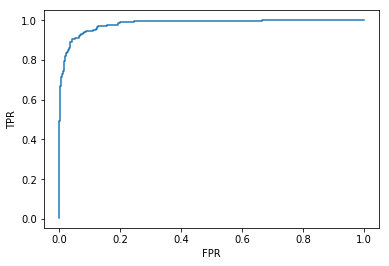

In [6]:
calcEER(cos_1, res)

# Linear comb of kl, zscore, and some other dist to optimize EER?

# Optimization

In [18]:
def EER(weights, *args):
    series = np.sum(np.multiply(weights.reshape(-1,1), np.vstack(args)),axis=0)
    fpr, tpr, thresholds = roc_curve(res, series)
    fnr = 1 - tpr
    return fpr[np.nanargmin(np.absolute((fnr - fpr)))]

In [19]:
# 'Newton-CG' , 'dogleg' , 'trust-ncg'- excluded, need jacobian
#methods = ['Nelder-Mead','Powell','CG','BFGS','L-BFGS-B','TNC','COBYLA','SLSQP' ]
methods = ['Nelder-Mead','Powell', 'COBYLA']

In [48]:
showH5('scores.h5')

['/cos_10', '/cos_samp_100k', '/kl_frame_100k', '/manhattan_spk_samp_100k', '/var_samp_100k', '/zscore_samp_100k']


# Cos, Z, KL Frame-level Trials (smaller dataset 100k)
Frame-level trials is on such a small dataset because it took a very long time to compute 

In [36]:
cos_data = pd.read_hdf('scores.h5', 'cos_samp_100k')
zscore_data = pd.read_hdf('scores.h5', 'zscore_samp_100k')
kl_data = pd.read_hdf('scores.h5', 'kl_frame_100k')

cos_scores = cos_data.loc[0].values[:100000]
zscore_scores = zscore_data.loc[0].values[:100000]
kl_scores = kl_data.loc[0].values
res = cos_data.loc[1].values[:100000]

In [21]:
for m in methods:
    r = minimize(EER, np.array([1,0,0]), args = (cos_scores, zscore_scores, kl_scores), method=m)
    print(m, r.fun, r.x)

print("Baseline: ", EER(np.array([1,0,0]), cos_scores, zscore_scores, kl_scores))

Powell 0.07779057539185738 [ 3.69370293  0.06017137 -0.22348872]
COBYLA 0.08466122489859282 [ 0.99609709 -0.00310737  0.06251464]
Baseline:  0.09104111372627573


In [37]:
for m in methods:
    r = minimize(EER, np.array([1,-0.5,-0.5]), args = (cos_scores, zscore_scores, kl_scores), method=m)
    print(m, r.fun, r.x)

print("Baseline: ", EER(np.array([1,0,0]), cos_scores, zscore_scores, kl_scores))

Powell 0.08247784065301217 [107.94532018  -0.49418232  -0.11202656]
COBYLA 0.07945315238619861 [2.07762437 0.0172337  0.52094385]
Baseline:  0.09104111372627573


In [38]:
kl_data = pd.read_hdf('scores.h5', 'kl_samp_100k')
kl_scores = kl_data.loc[0].values[:100000]

In [39]:
for m in methods:
    r = minimize(EER, np.array([1,-0.5,-0.5]), args = (cos_scores, zscore_scores, kl_scores), method=m)
    print(m, r.fun, r.x)

print("Baseline: ", EER(np.array([1,0,0]), cos_scores, zscore_scores, kl_scores))

Powell 0.07299313936601733 [ 6.60328256e+00  1.04412584e-01 -2.82944021e+02]
COBYLA 0.08279833742300566 [ 2.36249913 -0.0109397  -0.49229138]
Baseline:  0.09104111372627573


In [35]:
for m in methods:
    r = minimize(EER, np.array([1,0,0]), args = (cos_scores, zscore_scores, kl_scores), method=m)
    print(m, r.fun, r.x)

print("Baseline: ", EER(np.array([1,0,0]), cos_scores, zscore_scores, kl_scores))

Powell 0.07299313936601733 [ 3.49325108e+00  5.54224479e-02 -1.49316884e+02]
COBYLA 0.0841404176473534 [1.00373648 0.01648323 0.9998885 ]
Baseline:  0.09104111372627573


# Cos, Z, KL Trials 0.10 data

In [22]:
cos_data = pd.read_hdf('scores.h5', 'cos_10')
zscore_data = pd.read_hdf('scores.h5', 'zscore_10')
kl_data = pd.read_hdf('scores.h5', 'kl_spkr_10')

cos_scores = cos_data.loc[0].values
zscore_scores = zscore_data.loc[0].values
kl_scores = kl_data.loc[0].values
res = cos_data.loc[1].values

In [23]:
for m in methods:
    r = minimize(EER, np.array([1,-0.5,-0.5]), args = (cos_scores, zscore_scores, kl_scores), method=m)
    print(m, r.fun, r.x)
    
print("Baseline: ", EER(np.array([1,0, 0]), cos_scores, zscore_scores, kl_scores))

Powell 0.08000256251468107 [  46.38144191   -0.27570691 -189.10096246]
COBYLA 0.08085673407503897 [ 2.54225563 -0.0143544  -0.35539816]
Baseline:  0.08507121655384484


# Cos, Z, KL, Manhattan trials
- Powell yields a 0.7% improvement from baseline. However, scalars are not consistent. 

In [24]:
cos_data = pd.read_hdf('scores.h5', 'cos_10')
zscore_data = pd.read_hdf('scores.h5', 'zscore_10')
kl_data = pd.read_hdf('scores.h5', 'kl_spkr_10')
m_data = pd.read_hdf('scores.h5', 'manhattan_spkr_10')

cos_scores = cos_data.loc[0].values
zscore_scores = zscore_data.loc[0].values
kl_scores = kl_data.loc[0].values
m_scores = m_data.loc[0].values
res = cos_data.loc[1].values

In [25]:
for m in methods:
    r = minimize(EER, np.array([1,-0.5,-0.5, -0.5]), args = (cos_scores, zscore_scores, kl_scores, m_scores), method=m)
    print(m, r.fun, r.x)
    
print("Baseline: ", EER(np.array([1,0, 0, 0]), cos_scores, zscore_scores, kl_scores, m_scores))

Powell 0.07849409553908902 [113.98318403  -0.64186773  -3.87944643   0.36483302]
COBYLA 0.09663669948109077 [ 1.97326368 -0.58999121 -0.75009292 -1.45129054]
Baseline:  0.08507121655384484


In [14]:
for m in methods:
    r = minimize(EER, np.array([1,1,1, 1]), args = (cos_scores, zscore_scores, kl_scores, m_scores), method=m)
    print(m, r.fun, r.x)

Nelder-Mead 0.8981332080548378 [1.16644511 0.85630551 1.03975525 0.97870725]
Powell 0.07867347156676419 [167.23120306  -0.82396087 -81.41157443   0.51940213]
Baseline:  0.08507121655384484


In [15]:
for m in methods:
    r = minimize(EER, np.array([1,-1,-1, -1]), args = (cos_scores, zscore_scores, kl_scores, m_scores), method=m)
    print(m, r.fun, r.x)

Nelder-Mead 0.09855858549189604 [ 1.01988402 -1.04132503 -0.99334659 -0.99601366]
Powell 0.07876486792372248 [300.86359111  -1.46691945  15.76338169   0.91926267]
Baseline:  0.08507121655384484


# Cos, Z, KL, Manhattan, Cosine is a constant

In [3]:
cos_data = pd.read_hdf('scores.h5', 'cos_10')
zscore_data = pd.read_hdf('scores.h5', 'zscore_10')
kl_data = pd.read_hdf('scores.h5', 'kl_spkr_10')
m_data = pd.read_hdf('scores.h5', 'manhattan_spkr_10')

cos_scores = cos_data.loc[0].values
zscore_scores = zscore_data.loc[0].values
kl_scores = kl_data.loc[0].values
m_scores = m_data.loc[0].values
res = cos_data.loc[1].values

In [13]:
def EER(weights, *args):
    series = 100*cos_scores + np.sum(np.multiply(weights.reshape(-1,1), np.vstack(args)),axis=0)
    fpr, tpr, thresholds = roc_curve(res, series)
    fnr = 1 - tpr
    return fpr[np.nanargmin(np.absolute((fnr - fpr)))]

In [11]:
methods = ['Powell','COBYLA']

In [25]:
for m in methods:
    r = minimize(EER, np.array([-1,-1,-1]), args = (zscore_scores, kl_scores, m_scores), method=m)
    print(m, r.fun, r.x)
    
print("Baseline: ", EER(np.array([0, 0, 0]), zscore_scores, kl_scores, m_scores))

Nelder-Mead 0.08291785005018258 [-0.94469867 -0.97503329 -1.21859892]
Powell 0.08242072220205428 [ 1.62303041e-02 -2.71786916e+02 -1.24091739e+00]
CG 0.08434517072754062 [-1. -1. -1.]
BFGS 0.08434517072754062 [-1. -1. -1.]
L-BFGS-B 0.08434517072754062 [-1. -1. -1.]
TNC 0.08434517072754062 [-1. -1. -1.]
COBYLA 0.08307074675948664 [ 0.00756852 -1.00005078 -1.02451957]
SLSQP 0.08434517072754062 [-1. -1. -1.]
Baseline:  0.08507121655384484


In [26]:
for m in methods:
    r = minimize(EER, np.array([-0.5,-0.5,-0.5]), args = (zscore_scores, kl_scores, m_scores), method=m)
    print(m, r.fun, r.x)

Nelder-Mead 0.08276922419868031 [-0.51154805 -0.52052286 -0.46807044]
Powell 0.07932178778107583 [-0.68732026  3.02417828  0.21355502]
CG 0.0833594567468876 [-0.5 -0.5 -0.5]
BFGS 0.0833594567468876 [-0.5 -0.5 -0.5]
L-BFGS-B 0.0833594567468876 [-0.5 -0.5 -0.5]
TNC 0.0833594567468876 [-0.5 -0.5 -0.5]
COBYLA 0.07849751222533045 [-0.55645649  0.49673733  0.31624758]
SLSQP 0.0833594567468876 [-0.5 -0.5 -0.5]


Threshold:  7.466514835762768
EER/FPR:  0.8926861560144355
FNR:  0.8929561841375485


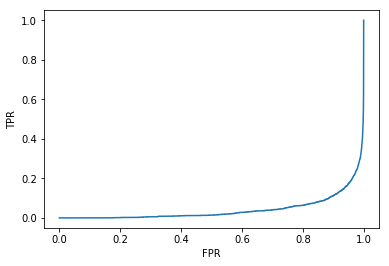

In [29]:
calcEER(m_scores, res)

# Cos, Variance

In [9]:
showH5('scores.h5')

['/cos_10', '/cos_samp_100k', '/kl_frame_100k', '/kl_spkr_10', '/manhattan_spk_samp_100k', '/manhattan_spkr_10', '/var_10', '/var_samp_100k', '/zscore_10', '/zscore_samp_100k']


In [10]:
cos_data = pd.read_hdf('scores.h5', 'cos_10')
zscore_data = pd.read_hdf('scores.h5', 'zscore_10')
kl_data = pd.read_hdf('scores.h5', 'kl_spkr_10')
m_data = pd.read_hdf('scores.h5', 'manhattan_spkr_10')
var_data = pd.read_hdf('scores.h5', 'var_10')

cos_scores = cos_data.loc[0].values
zscore_scores = zscore_data.loc[0].values
kl_scores = kl_data.loc[0].values
m_scores = m_data.loc[0].values
var = var_data.loc[0].values
res = cos_data.loc[1].values

In [18]:
for m in methods:
    r = minimize(EER, np.array([100]), args = (var), method=m)
    print(m, r.fun, r.x)
    
print("Baseline: ", EER(np.array([0]), var))

Powell 0.08328685216425719 129.2983237163476
COBYLA 0.08328685216425719 [129.296875]
Baseline:  0.08507121655384484


## Results indicate Variance can improve EER slightly with these scalars.

# Testing optimization results on larger datasets 

In [19]:
cos_50 , res_50= run_test(cos_similarity, 0.5, enroll_spk, test_spk, pairs=pairs)
sendScores(cos_50, res_50, 'cos_50')

[########################################] | 100% Completed |  0.5s
[########################################] | 100% Completed |  5min  9.5s
[########################################] | 100% Completed |  1.6s


In [20]:
var_50 , res_50= run_test(getVar, 0.5, enroll_spk_raw, test_spk, pairs=pairs)
sendScores(var_50, res_50, 'var_50')

[########################################] | 100% Completed |  0.5s
[########################################] | 100% Completed | 11min 11.3s
[########################################] | 100% Completed |  1.4s


Threshold:  0.9147632933420125
EER/FPR:  0.07963749733077087
FNR:  0.07962713387241693


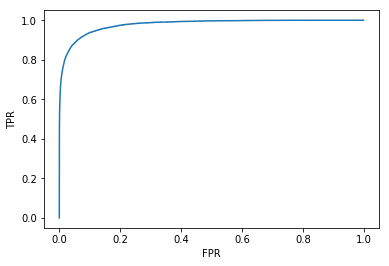

In [24]:
calcEER(cos_50, res_50)

Threshold:  91.5573446308528
EER/FPR:  0.07961341020713218
FNR:  0.07962713387241693


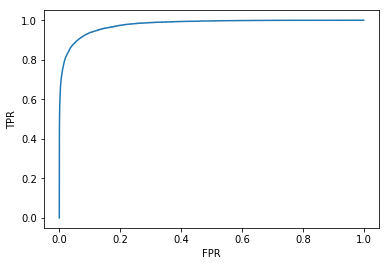

In [22]:
calcEER(cos_50*100+var_50*129, res_50)

In [36]:
cos_scores = cos_50
res = res_50

In [5]:
def EER(weights, *args):
    series = 100*cos_scores + np.sum(np.multiply(weights.reshape(-1,1), np.vstack(args)),axis=0)
    fpr, tpr, thresholds = roc_curve(res, series)
    fnr = 1 - tpr
    return fpr[np.nanargmin(np.absolute((fnr - fpr)))]

In [44]:
for m in methods:
    r = minimize(EER, np.array([10000]), args = (var_50), method=m)
    print(m, r.fun, r.x)
    
print("Baseline: ", EER(np.array([0]), var_50))

Powell 0.0795250907537903 16.865929594608627
COBYLA 0.18439564381806534 [9991.8125]
Baseline:  0.07963749733077087


## Results - VAR has a minimal impact on EER on a larger sample set

# All variables on a larger sample set
We use all variables to observe how they change on a different sample size and set

In [40]:
showH5('scores.h5')

['/cos_10', '/cos_50', '/cos_samp_100k', '/kl_frame_100k', '/kl_samp_100k', '/kl_spkr_10', '/kl_spkr_50', '/manhattan_50', '/manhattan_spk_samp_100k', '/manhattan_spkr_10', '/var_10', '/var_50', '/var_samp_100k', '/zscore_10', '/zscore_50', '/zscore_samp_100k']


In [41]:
cos_data = pd.read_hdf('scores.h5', 'cos_50')
var_data = pd.read_hdf('scores.h5', 'var_50')
kl_data = pd.read_hdf('scores.h5', 'kl_spkr_50')
z_data = pd.read_hdf('scores.h5', 'zscore_50')
m_data = pd.read_hdf('scores.h5', 'manhattan_50')

cos_scores = cos_data.loc[0].values
kl_scores = kl_data.loc[0].values
z_scores = z_data.loc[0].values
m_scores = m_data.loc[0].values
var = var_data.loc[0].values
res = cos_data.loc[1].values

Threshold:  7.458965499190901
EER/FPR:  0.8947102284860132
FNR:  0.8946540880503144


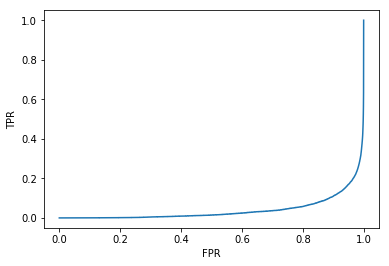

In [42]:
calcEER(m_scores, res)

Threshold:  0.9997187033734809
EER/FPR:  0.10586034593209481
FNR:  0.10590745732255169


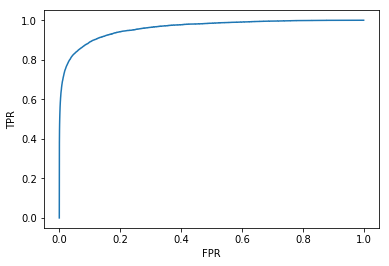

In [13]:
calcEER(1-kl_scores, res)

In [15]:
m_data = pd.read_hdf('scores.h5', 'manhattan_50')

m_scores = m_data.loc[0].values

Threshold:  -6.458965389225629
EER/FPR:  0.10528977151398676
FNR:  0.10534591194968557


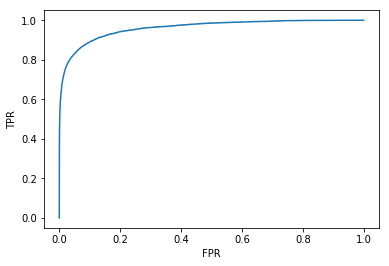

In [17]:
calcEER(1-m_scores, res)

In [44]:
def EER(weights, *args):
    series = np.sum(np.multiply(weights.reshape(-1,1), np.vstack(args)),axis=0)
    fpr, tpr, thresholds = roc_curve(res, series)
    fnr = 1 - tpr
    return fpr[np.nanargmin(np.absolute((fnr - fpr)))]

In [45]:
for m in methods:
    r = minimize(EER, np.array([1, -0.5, -0.5, -0.5]), args = (cos_scores, kl_scores, z_scores, m_scores), method=m)
    print(m, r.fun, r.x)
    
print("Baseline: ", EER(np.array([1, 0,0,0]),cos_scores, kl_scores, z_scores, m_scores))

Powell 0.07943181721118941 [ 5.68287866e+01  7.72409233e+01  3.69285485e-02 -2.31777927e-02]
COBYLA 0.09164894298526585 [ 2.25022564  0.43747277 -0.5240326  -0.73678336]
Baseline:  0.07963749733077087


# No Cos

In [4]:
def EER(weights, *args):
    series = np.sum(np.multiply(weights.reshape(-1,1), np.vstack(args)),axis=0)
    fpr, tpr, thresholds = roc_curve(res, series)
    fnr = 1 - tpr
    return fpr[np.nanargmin(np.absolute((fnr - fpr)))]

In [7]:
for m in methods:
    r = minimize(EER, np.array([-0.5, 5]), args = (kl_scores, var), method=m)
    print(m, r.fun, r.x)

Powell 0.10155592568866112 [-172.75814613    4.98880963]
COBYLA 0.10154533418748665 [-9.6914616   0.29579291]


# Conclusions
- In terms of individual indicators, cosine similarity still performs the best with a **8.5%** EER in this data sample. Other individual test results are as follows:


- **zscore:** 13%
- **kl:** 11%
- **manhattan distance:** 11%

- The best combination of factors seems to be:
1. (cos, zscore, kl, manhattan)
2. (zscore, kl, manhattan) if cosine is set to a constant scalar of **100**. 

These yield an EER of **7.8%** on the 0.1 sample.

# Analysis 

In [8]:
cos_data = pd.read_hdf('scores.h5', 'cos_10')
zscore_data = pd.read_hdf('scores.h5', 'zscore_10')
kl_data = pd.read_hdf('scores.h5', 'kl_spkr_10')
m_data = pd.read_hdf('scores.h5', 'manhattan_spkr_10')
var_data = pd.read_hdf('scores.h5', 'var_10')

cos_scores = cos_data.loc[0].values
zscore_scores = zscore_data.loc[0].values
kl_scores = kl_data.loc[0].values
m_scores = m_data.loc[0].values
var = var_data.loc[0].values
res = cos_data.loc[1].values

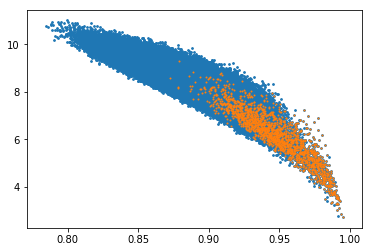

In [16]:
plt.scatter(cos_scores, m_scores, s=3)
plt.scatter(cos_scores[res==1], m_scores[res==1], s=1)

In [7]:
cos_data = pd.read_hdf('scores.h5', 'cos_samp_100k')
zscore_data = pd.read_hdf('scores.h5', 'zscore_samp_100k')
kl_data = pd.read_hdf('scores.h5', 'kl_frame_100k')

cos_scores = cos_data.loc[0].values[:100000]
zscore_scores = zscore_data.loc[0].values[:100000]
kl_scores = kl_data.loc[0].values
res = cos_data.loc[1].values[:100000]

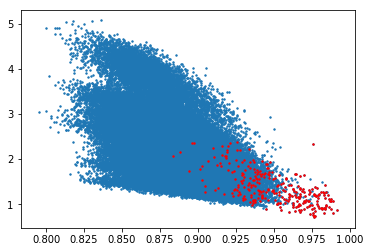

In [13]:
plt.scatter(cos_scores, zscore_scores, s=2)
plt.scatter(cos_scores[res==1], zscore_scores[res==1], s=2, c='red')

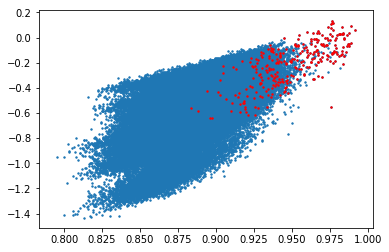

In [62]:
plt.scatter(cos_scores, cos_scores-np.sqrt(zscore_scores), s=2)
plt.scatter(cos_scores[res==1], (cos_scores-np.sqrt(zscore_scores))[res==1], s=2, c='red')

In [50]:
kl_data = pd.read_hdf('scores.h5', 'kl_frame_100k')

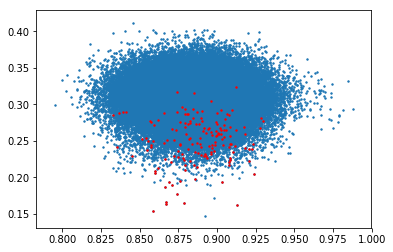

In [55]:
plt.scatter(cos_scores[:100000], kl_data.loc[0].values, s=2)
plt.scatter(cos_scores[:100000][kl_data.loc[1].values==1], kl_data.loc[0].values[kl_data.loc[1].values==1], s=2, c='red')